# Click processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import wavio as wv

plt.rc('font', size=15)

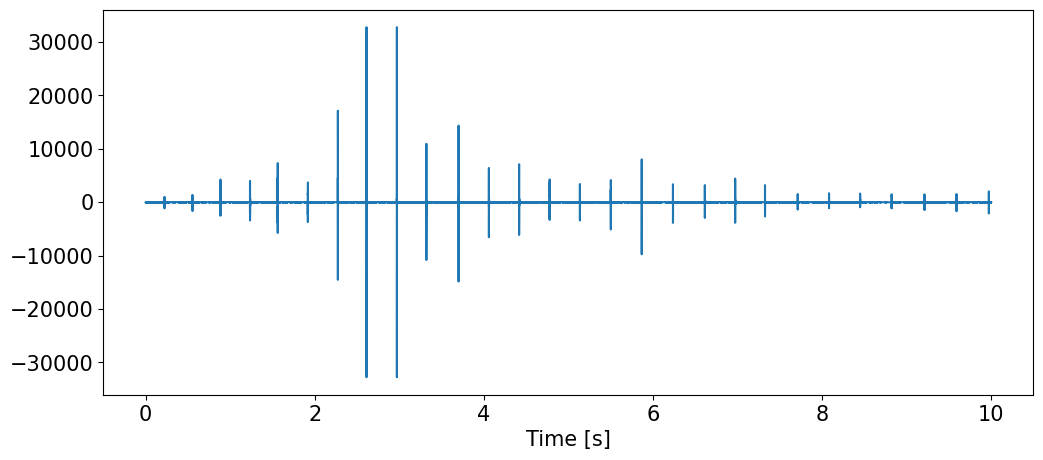

In [2]:
wav=wv.read("./Data/zc06_204a22410-24210.wav")
fs=wav.rate
data=wav.data[int(4*fs):int(14*fs),:]
tt=np.arange(data.shape[0])/fs
plt.figure(figsize=(12,5))
plt.plot(tt,data)
plt.xlabel('Time [s]')
plt.show()

1.4142135623730951
[0.145 0.145 0.145 0.145 0.145 0.145] m
[5.17241379 5.17241379 5.17241379 5.17241379 5.17241379 5.17241379] kHz


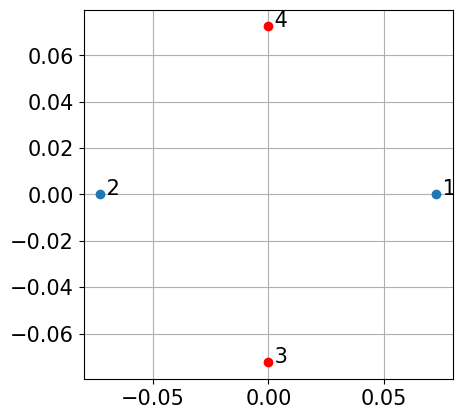

In [3]:
#hydrophone configuration
dz=np.sqrt(0.5)
print(2*dz)
ho=np.array([[1,0,-dz],[-1,0,-dz],[0,-1,dz],[0,1,dz]])*0.0725

hsel=np.array([[1,0],[2,0],[3,0],[2,1],[3,1],[3,2]])    # hsel[:,1] is reference
nc=hsel.shape[0]
D=ho[hsel[:,0],:]-ho[hsel[:,1],:]
L=np.sqrt(np.sum(D**2,1))
print(L,'m')
print(0.75/L, 'kHz')
DI=np.linalg.pinv(D)
#
plt.plot(ho[:2,0],ho[:2,1],'o')     # bottom
plt.plot(ho[2:,0],ho[2:,1],'ro')    # top
plt.text(ho[0,0],ho[0,1],' 1')
plt.text(ho[1,0],ho[1,1],' 2')
plt.text(ho[2,0],ho[2,1],' 3')
plt.text(ho[3,0],ho[3,1],' 4')
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

In [4]:
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
# modified by WMXZ to work on multi-channel data
#
def fft_filt(b, x, zi=None, nh=0):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.
    nh : time shift of result (group delay)

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    if x.ndim==1: x=x.reshape(-1,1)
    if b.ndim==1: b=b.reshape(-1,1)
    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig,N_sig = x.shape
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros((L_sig+L_F,N_sig), dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros((L_sig+L_F,N_sig))

    FDir = fft_func(b, n=L_F,axis=0)

    # overlap and add
    for n in offsets:
        res[n:n+L_F,:] += ifft_func(fft_func(x[n:n+L_S,:], n=L_F,axis=0)*FDir,axis=0)

    if zi is not None:
        res[:zi.shape[0],:] = res[:zi.shape[0],:] + zi
        zi=res[L_sig:,:]
        return res[nh:nh+L_sig,:],zi 
    else:
        return res[nh:nh+L_sig,:]

def sim_array(yy,fs,DT,noise):
    # delay signal according to array geometry 
    # (use fractional delay with sinc function)
    kk=np.arange(-10,10,1);
    ss=np.zeros((len(yy),len(DT)))
    for ii in range(len(DT)):
        ss[:,ii]=fft_filt(np.sinc(kk+DT[ii]*fs/1000),yy)[:,0]

    nn=np.random.normal(scale=noise, size=ss.shape)
    ss +=nn
    return ss

def quadInt(uu,imx,nd1):
    # three point quardatic interpolation 
    # to find location and value of interpolated maxima
    nc=len(imx)
    uo=uu[imx,range(nc)]
    um=uu[imx-1,range(nc)]
    up=uu[imx+1,range(nc)]

    b=(up+um-2*uo)/2;

    xo=(um-up)/(4*b);
    yo=uo-b*xo**2;
    
    ux=np.zeros((nc,2))
    ux[:,0]=xo+imx-nd1
    ux[:,1]=yo
    return ux


In [5]:
## simulate delay
azo=60
elo=10
az= azo*np.pi/180
el= elo*np.pi/180
S=np.array([np.cos(az)*np.cos(el),np.sin(az)*np.cos(el), np.sin(el)])
DC=np.sum(ho*S,1)
DT=DC/1.500   # ms
print(DT, 'ms')

[ 0.01786478 -0.02973426 -0.03528724  0.04715672] ms


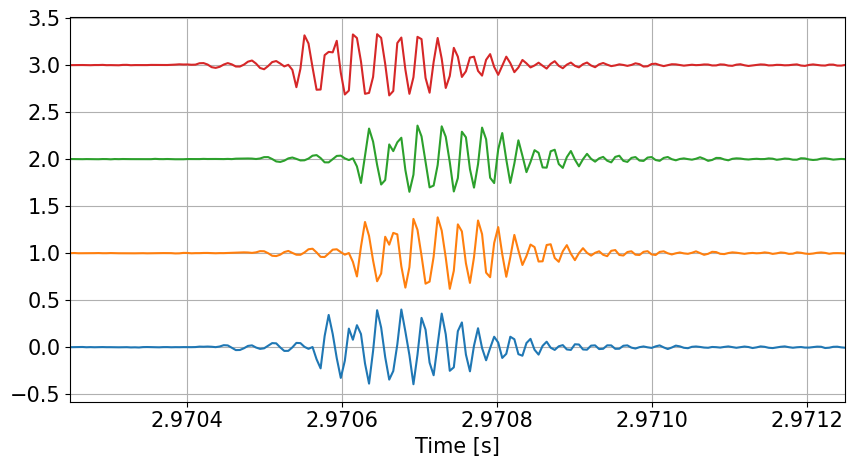

In [6]:
#delay signal according to array geometry
ss=sim_array(data,fs,DT,100)
ts=np.arange(ss.shape[0])/fs
#
xl=[]
xl=[2.97025,2.97125]
plt.figure(figsize=(10,5))
plt.plot(ts,0.4*ss/np.max(ss)+np.ones((ss.shape[0],1))*np.arange(len(DT)));
plt.grid(True)
if xl != []: plt.xlim(xl)
plt.xlabel('Time [s]')
plt.show()

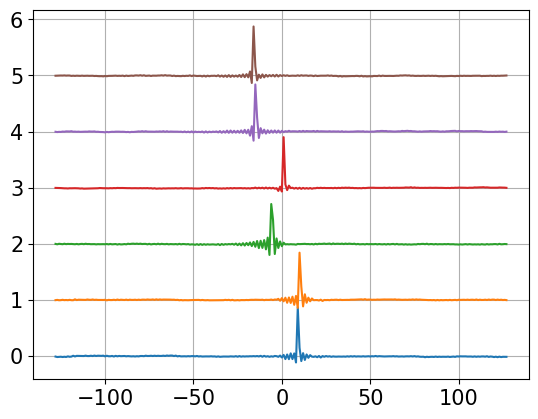

In [7]:
# check processing
io=int(2.97*fs)
xx=ss[io:io+256,:]
#plt.plot(xx)
#plt.show()
#
uu=np.fft.rfft(xx,axis=0)
vv=uu[:,hsel[:,0]]*np.conjugate(uu[:,hsel[:,1]])
vv /= np.abs(vv)
yy=np.fft.fftshift(np.fft.irfft(vv,axis=0),axes=0)
amx= yy.max(axis=0)
jmx= yy.argmax(axis=0)

plt.plot(np.arange(-128,128),0.9*yy/np.max(yy)+np.ones((yy.shape[0],1))*np.arange(hsel.shape[0]));
plt.grid(True)
plt.show()

In [8]:
#
def xcorr(xx,hsel):
    nx=xx.shape[0]
    uu=np.fft.rfft(xx,axis=0)
    vv=uu[:,hsel[:,0]]*np.conjugate(uu[:,hsel[:,1]])
    vv /= np.abs(vv)
    yy=np.fft.fftshift(np.fft.irfft(vv,axis=0),axes=0)
    amx= yy.max(axis=0)
    jmx= yy.argmax(axis=0)
    #
    jmx=np.minimum(jmx,nx-2)
    jmx=np.maximum(jmx,1)
    ux=quadInt(yy,jmx,128)
    return amx,jmx,ux

offsets=np.arange(0,ss.shape[0]-256,128,dtype=int)
imx=np.zeros((len(offsets),hsel.shape[0]),dtype=int)
amx=np.zeros((len(offsets),hsel.shape[0]))
#
ux=np.zeros((len(offsets),6,2))
jj=0
for ii in offsets:
    xx=ss[ii:ii+256,:]
    amx[jj,:],imx[jj,:],ux[jj,:,:]=xcorr(xx,hsel)
    jj += 1


In [9]:
print(ux.shape)
imx1=ux[:,:,0]
amx1=ux[:,:,1]

(14998, 6, 2)


19.0
(14998,)


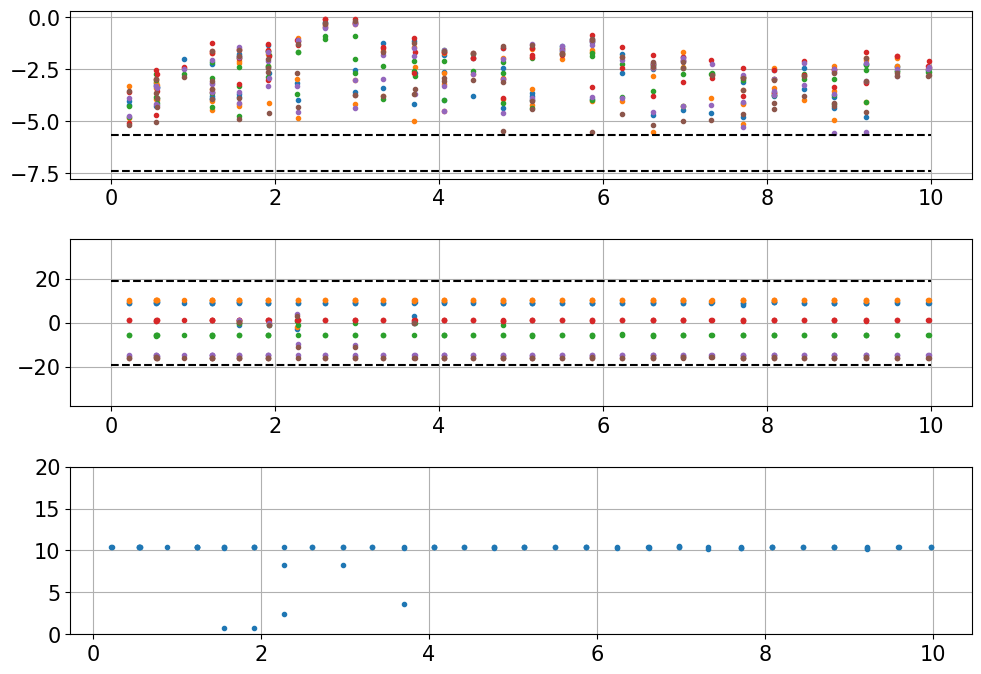

In [10]:
xl=[]
#
dn=np.ceil(np.max(L)/1500*fs)
print(dn)
td=ts[offsets]
#
thr=amx1.mean()+1*amx1.std()
idet=np.all(amx1>thr,axis=1)
print(idet.shape)
#
plt.figure(figsize=(10,7),layout='tight')
plt.subplot(311)
plt.plot(td[idet],10*np.log10(amx1[idet,:]),'.')
plt.hlines(10*np.log10(amx1.mean()),td[0],td[-1],linestyles='--',color='k')
plt.hlines(10*np.log10(thr),td[0],td[-1],linestyles='--',color='k')
plt.grid(True)
if xl !=[]: plt.xlim(xl)

plt.subplot(312)
plt.plot(td[idet],imx1[idet,:],'.')
if xl !=[]: plt.xlim(xl)
#plt.hlines(0,td[0],td[-1],linestyles='--')
plt.hlines(+dn,td[0],td[-1],linestyles='--',color='k')
plt.hlines(-dn,td[0],td[-1],linestyles='--',color='k')
plt.grid(True)
plt.ylim(-2*dn,+2*dn)

plt.subplot(313)
plt.plot(td[idet],imx1[idet,:].std(axis=1),'.')
plt.ylim(0,20)
plt.grid(True)
if xl !=[]: plt.xlim(xl)
plt.show()

(14998, 3)


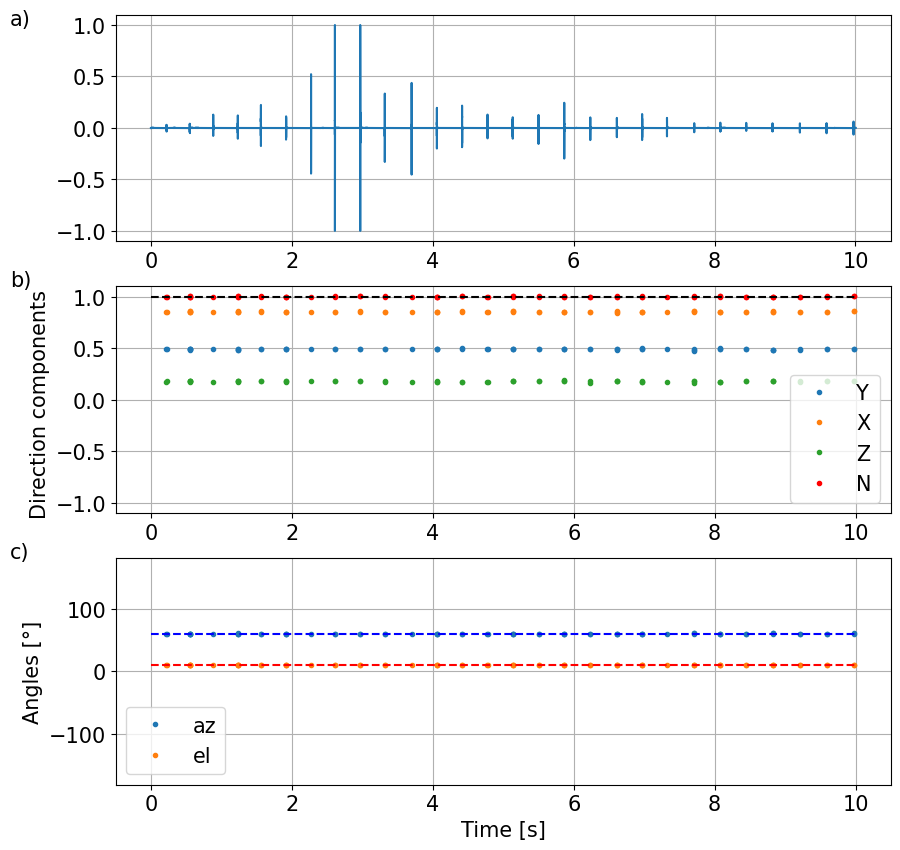

In [11]:
z=-imx1@DI.T
z *= 1500/fs 
zn=np.sqrt(np.sum(z**2,1))
print(z.shape)
#
az=np.arctan2(z[:,1],z[:,0])*180/np.pi
el=np.arctan2(z[:,2],np.sqrt(z[:,0]**2+z[:,1]**2))*180/np.pi
#
jdet=idet & (np.abs(zn-1)<0.01)
#
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(ts,data/2**15)
plt.grid(True)
plt.text(-2,1,'a)')

plt.subplot(312)
plt.plot(td[jdet],z[jdet,:],'.',label={'X','Y','Z'})
plt.plot(td[jdet],zn[jdet],'r.',label='N')
plt.hlines(1,td[0],td[-1],linestyles='--',color='k')
plt.ylim(-1.1,1.1)
plt.ylabel('Direction components ' )
plt.legend()
plt.text(-2,1.1,'b)')
plt.grid(True)

plt.subplot(313)
plt.plot(td[jdet],az[jdet],'.', label='az')
plt.plot(td[jdet],el[jdet],'.', label='el')
plt.hlines(azo,td[0],td[-1],linestyles='--',color='b')
plt.hlines(elo,td[0],td[-1],linestyles='--',color='r')
plt.ylim(-180,180)
plt.legend()
plt.grid(True)
plt.ylabel('Angles [°]' )
plt.xlabel('Time [s]' )
plt.text(-2,180,'c)')
plt.show()
